In [16]:
import cv2
import numpy as np

image = cv2.imread('color_splash.jpeg')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
blur = cv2.medianBlur(hsv ,11)

lower = np.array([0,0,0])
upper = np.array([140,153,255])

mask = cv2.inRange(blur, lower, upper)
res = cv2.bitwise_and(image,image, mask= mask)            

cv2.imshow("mask ",mask)
cv2.imshow('stack', np.hstack([image, res]))
cv2.waitKey(0)



-1

# Object Tracking with SIFT Algorithm using OpenCV

In [3]:
# Import necessary libraries
import cv2 
import numpy as np
import matplotlib.pyplot as plt 

In [4]:
# Path to video  
# video_path="takeoff_2.mp4" 
video_path="takeoff_2.mp4" 
video_path="soccer.mp4" 
video = cv2.VideoCapture(video_path)

# read only the first frame for drawing a rectangle for the desired object
ret,frame = video.read()
frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)


# I am giving  big random numbers for x_min and y_min because if you initialize them as zeros whatever coordinate you go minimum will be zero 
x_min,y_min,x_max,y_max=36000,36000,0,0


def coordinat_chooser(event,x,y,flags,param):
    global go , x_min , y_min, x_max , y_max

    # when you click the right button, it will provide coordinates for variables
    if event==cv2.EVENT_RBUTTONDOWN:
        
        # if current coordinate of x lower than the x_min it will be new x_min , same rules apply for y_min 
        x_min=min(x,x_min) 
        y_min=min(y,y_min)

         # if current coordinate of x higher than the x_max it will be new x_max , same rules apply for y_max
        x_max=max(x,x_max)
        y_max=max(y,y_max)

        # draw rectangle
        cv2.rectangle(frame,(x_min,y_min),(x_max,y_max),(0,255,0),1)

    if event==cv2.EVENT_MBUTTONDOWN:
        print("reset coordinate  data")
        x_min,y_min,x_max,y_max=36000,36000,0,0

cv2.namedWindow('coordinate_screen')
# Set mouse handler for the specified window, in this case, "coordinate_screen" window
cv2.setMouseCallback('coordinate_screen',coordinat_chooser)


while True:
    cv2.imshow("coordinate_screen",frame) # show only first frame 
    
    k = cv2.waitKey(5) & 0xFF # after drawing rectangle press ESC   
    if k == 27:
        cv2.destroyAllWindows()
        break

# TRACK

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

# Path to video
# video_path = "takeoff_2.mp4"
video_path = "soccer.mp4"
video = cv2.VideoCapture(video_path)

# Read the first frame for drawing a rectangle for the desired object
ret, frame = video.read()
frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)

if not ret:
    print("Failed to read the video.")
    exit()

# Initialize variables for ROI selection
drawing = False  # True if the mouse is pressed
ix, iy = -1, -1  # Initial x, y coordinates of the mouse click
x_min, y_min, x_max, y_max = 0, 0, 0, 0
roi_selected = False  # Flag to check if ROI is selected
roi_gray = None  # To store the grayscale image of ROI
kp1, des1 = None, None  # Keypoints and descriptors of the ROI

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Function to select coordinates by clicking and dragging the mouse
def coordinate_chooser(event, x, y, flags, param):
    global ix, iy, drawing, x_min, y_min, x_max, y_max, roi_selected, roi_gray, kp1, des1

    # Start drawing on left button down
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y
        x_min, y_min = x, y
        x_max, y_max = x, y

    # Update rectangle while moving the mouse
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            x_min, y_min = min(ix, x), min(iy, y)
            x_max, y_max = max(ix, x), max(iy, y)

    # Finalize drawing on left button release
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x_min, y_min = min(ix, x), min(iy, y)
        x_max, y_max = max(ix, x), max(iy, y)
        # Draw the final rectangle on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Save the selected object
        roi_image = frame[y_min:y_max, x_min:x_max]
        if roi_image.size > 0:  # Check if ROI is valid
            roi_gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
            kp1, des1 = sift.detectAndCompute(roi_gray, None)  # Extract keypoints and descriptors
            roi_selected = True
            print("Region of Interest defined and SIFT features extracted.")

    # Reset coordinates with middle button click
    elif event == cv2.EVENT_MBUTTONDOWN:
        print("Reset coordinate data")
        x_min, y_min, x_max, y_max = 0, 0, 0, 0
        roi_selected = False


# Create a window and set the mouse callback function
cv2.namedWindow('coordinate_screen')
cv2.setMouseCallback('coordinate_screen', coordinate_chooser)

while True:
    # Display the frame with the drawn rectangle
    temp_frame = frame.copy()
    
    if drawing:
        cv2.rectangle(temp_frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
    cv2.imshow("coordinate_screen", temp_frame)

    # Press ESC to exit selection mode
    k = cv2.waitKey(5) & 0xFF
    if k == 27 or roi_selected:  # Exit loop if ESC is pressed or ROI is selected
        break

# Start tracking if ROI is selected
if roi_selected:
    # Prepare the matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Tracking loop
    while video.isOpened():
        ret, frame = video.read()
        frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)

        if not ret:
            break

        # Convert the current frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect keypoints and descriptors in the current frame
        kp2, des2 = sift.detectAndCompute(gray_frame, None)

        # Match descriptors using FLANN matcher
        if des2 is not None:
            matches = flann.knnMatch(des1, des2, k=2)

            # Apply ratio test to filter good matches
            good_matches = []
            for m, n in matches:
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)

            # Minimum number of good matches required to track the object
            if len(good_matches) > 10:
                # Get the keypoints from the good matches
                src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

                # Find the perspective transformation
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                # Draw tracked object if homography is found
                if M is not None:
                    h, w = roi_gray.shape
                    pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
                    dst = cv2.perspectiveTransform(pts, M)
                    frame = cv2.polylines(frame, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

        # Display the frame with the tracked object
        cv2.imshow("SIFT Tracking", frame)

        # Press ESC to exit
        k = cv2.waitKey(30) & 0xFF
        if k == 27:
            break

# Release resources
video.release()
cv2.destroyAllWindows()


Region of Interest defined and SIFT features extracted.


376 785 918 1119


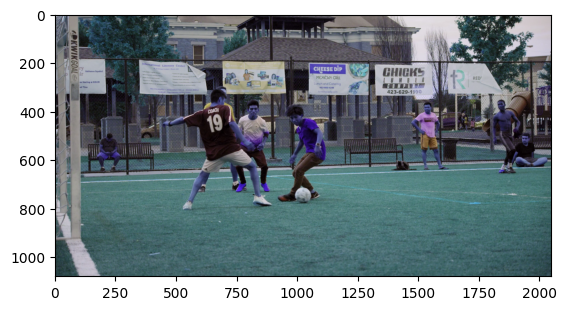

In [20]:
# Path to video
video_path = "soccer.mp4"
video = cv2.VideoCapture(video_path)

# Read the first frame for drawing a rectangle for the desired object
ret, frame = video.read()
frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)
print(y_min,y_max,x_min,x_max)
plt.imshow(frame)

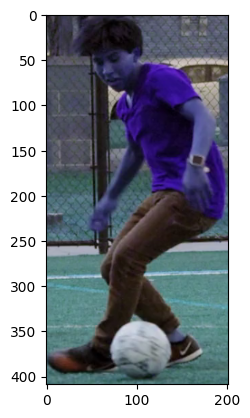

In [21]:
# take region of interest ( take inside of rectangle )
roi_image=frame[y_min:y_max,x_min:x_max]

# convert roi to grayscale, SIFT Algorithm works with grayscale images
roi_gray=cv2.cvtColor(roi_image,cv2.COLOR_BGR2GRAY) 
plt.imshow(roi_image)

In [22]:

# create SIFT algorithm object
sift = cv2.SIFT_create()

# find roi's keypoints and descriptors
keypoints_1, descriptors_1 = sift.detectAndCompute(roi_gray, None)

roi_keypoint_image=cv2.drawKeypoints(roi_gray,keypoints_1,roi_gray)

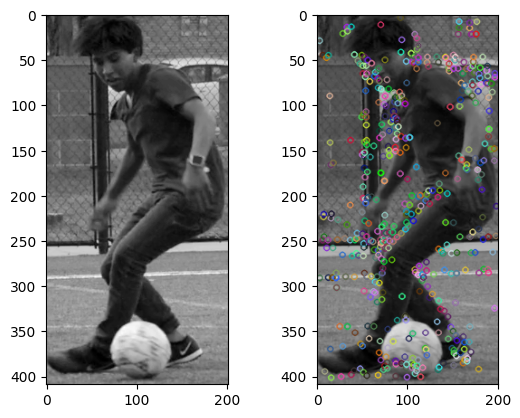

In [23]:
# visualize key points 
plt.subplot(121)
plt.imshow(roi_gray,cmap="gray")

plt.subplot(122)
plt.imshow(roi_keypoint_image,cmap="gray")

## Track target in video

In [5]:
# Path to the video  
video_path="soccer.mp4"  
video = cv2.VideoCapture(video_path)

# matcher object
bf = cv2.BFMatcher()

while True :
  # reading video 
  ret,frame=video.read()
  frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)

  # convert the frame to grayscale 
  frame_gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  
  # find current frames keypoints and descriptors
  keypoints_2, descriptors_2 = sift.detectAndCompute(frame_gray, None)

  # Check if descriptors are None to avoid errors during matching
  if descriptors_1 is not None and descriptors_2 is not None:
      # Match descriptors between the initial ROI and current frame
      matches = bf.match(descriptors_1, descriptors_2)

      # Sort matches based on their distance (lower distance is better)
      matches = sorted(matches, key=lambda x: x.distance)

      # Draw only the first 50 matches (or adjust as needed)
      for match in matches[:50]:
          # Get keypoint coordinates from the ROI (query) and current frame (train)
          query_idx = match.queryIdx
          train_idx = match.trainIdx

          # ROI keypoint coordinates
          pt1 = keypoints_1[query_idx].pt

          # Current frame keypoint coordinates
          pt2 = keypoints_2[train_idx].pt

          # Draw a small circle around the matched keypoint in the current frame
          cv2.circle(frame, (int(pt2[0]), int(pt2[1])), 4, (255, 0, 0), 2)

      # Display the current frame with matched keypoints
      cv2.imshow("SIFT Tracking", frame)

  # Exit loop when ESC is pressed
  k = cv2.waitKey(5) & 0xFF
  if k == 27:  # ESC key to exit
      break

# Release resources and close all windows
video.release()
cv2.destroyAllWindows()

NameError: name 'descriptors_1' is not defined

In [25]:
import cv2

# Path to the video
# video_path = "takeoff_2.mp4"
video_path = "soccer.mp4"
video = cv2.VideoCapture(video_path)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Read the first frame and select ROI (Replace this with your ROI selection code if necessary)
ret, frame = video.read()
frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)

if not ret:
    print("Failed to read the video.")
    video.release()
    exit()

# Convert the first frame to grayscale
frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Select ROI using mouse or define it manually
roi = cv2.selectROI("Select ROI", frame, False, False)
cv2.destroyWindow("Select ROI")

# Crop the ROI from the grayscale image
roi_gray = frame_gray[int(roi[1]):int(roi[1] + roi[3]), int(roi[0]):int(roi[0] + roi[2])]

# Find keypoints and descriptors in the ROI
keypoints_1, descriptors_1 = sift.detectAndCompute(roi_gray, None)

# Matcher object
bf = cv2.BFMatcher()

while True:
    # Read the current frame from the video
    ret, frame = video.read()
    frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)

    if not ret:
        print("End of video or error reading frame.")
        break

    # Convert the frame to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Find keypoints and descriptors in the current frame
    keypoints_2, descriptors_2 = sift.detectAndCompute(frame_gray, None)

    # Check if descriptors are None to avoid errors during matching
    if descriptors_1 is not None and descriptors_2 is not None:
        # Match descriptors between the initial ROI and current frame
        matches = bf.match(descriptors_1, descriptors_2)

        # Sort matches based on their distance (lower distance is better)
        matches = sorted(matches, key=lambda x: x.distance)

        # Draw only the first 50 matches (or adjust as needed)
        for match in matches[:50]:
            # Get keypoint coordinates from the ROI (query) and current frame (train)
            query_idx = match.queryIdx
            train_idx = match.trainIdx

            # ROI keypoint coordinates
            pt1 = keypoints_1[query_idx].pt

            # Current frame keypoint coordinates
            pt2 = keypoints_2[train_idx].pt

            # Draw a small circle around the matched keypoint in the current frame
            cv2.circle(frame, (int(pt2[0]), int(pt2[1])), 4, (255, 0, 0), 2)

        # Display the current frame with matched keypoints
        cv2.imshow("SIFT Tracking", frame)

    # Exit loop when ESC is pressed
    k = cv2.waitKey(5) & 0xFF
    if k == 27:  # ESC key to exit
        break

# Release resources and close all windows
video.release()
cv2.destroyAllWindows()


## Detecting and Tracking Moving Objects with Background Subtractors

https://medium.com/thedeephub/detecting-and-tracking-moving-objects-with-background-subtractors-using-opencv-f2ff7f94586f 

In [2]:
# import libraries
import cv2
import numpy as np

# KNN
KNN_subtractor = cv2.createBackgroundSubtractorKNN(detectShadows = True) # detectShadows=True : exclude shadow areas from the objects you detected

# MOG2
MOG2_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows = True) # exclude shadow areas from the objects you detected

# choose your subtractor
bg_subtractor=MOG2_subtractor

# camera = cv2.VideoCapture("takeoff_2.mp4")
camera = cv2.VideoCapture("birds.mp4")


while True:
    ret, frame = camera.read()
    frame = cv2.resize(frame, None, fx = 0.45, fy = 0.45)

    # Every frame is used both for calculating the foreground mask and for updating the background. 
    foreground_mask = bg_subtractor.apply(frame)

    # threshold if it is bigger than 240 pixel is equal to 255 if smaller pixel is equal to 0
    # create binary image , it contains only white and black pixels
    ret , treshold = cv2.threshold(foreground_mask.copy(), 120, 255,cv2.THRESH_BINARY)
    
    #  dilation expands or thickens regions of interest in an image.
    dilated = cv2.dilate(treshold,cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)),iterations = 2)
    
     # find contours 
    contours, hier = cv2.findContours(dilated,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # check every contour if are exceed certain value draw bounding boxes
    for contour in contours:
        # if area exceed certain value then draw bounding boxes
        if cv2.contourArea(contour) > 50:
            (x,y,w,h) = cv2.boundingRect(contour)
            cv2.rectangle(frame, (x,y), (x+w, y+h), (255, 255, 0), 2)

    cv2.imshow("Subtractor", foreground_mask)
    cv2.imshow("threshold", treshold)
    cv2.imshow("detection", frame)
    
    if cv2.waitKey(30) & 0xff == 27:
        break
        
camera.release()
cv2.destroyAllWindows()

## Object Tracking and Path Mapping Using Lucas-Kanade Optical Flow

### Draw object on first frame

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

# Path to video
# video_path = "takeoff_2.mp4"
video_path = "runner.mp4"
video = cv2.VideoCapture(video_path)

# Read the first frame for drawing a rectangle for the desired object
ret, frame = video.read()
frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)

if not ret:
    print("Failed to read the video.")
    exit()

# Initialize variables for ROI selection
drawing = False  # True if the mouse is pressed
ix, iy = -1, -1  # Initial x, y coordinates of the mouse click
x_min, y_min, x_max, y_max = 0, 0, 0, 0
roi_selected = False  # Flag to check if ROI is selected
roi_gray = None  # To store the grayscale image of ROI
kp1, des1 = None, None  # Keypoints and descriptors of the ROI

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Function to select coordinates by clicking and dragging the mouse
def coordinate_chooser(event, x, y, flags, param):
    global ix, iy, drawing, x_min, y_min, x_max, y_max, roi_selected, roi_gray, kp1, des1

    # Start drawing on left button down
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y
        x_min, y_min = x, y
        x_max, y_max = x, y

    # Update rectangle while moving the mouse
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            x_min, y_min = min(ix, x), min(iy, y)
            x_max, y_max = max(ix, x), max(iy, y)

    # Finalize drawing on left button release
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x_min, y_min = min(ix, x), min(iy, y)
        x_max, y_max = max(ix, x), max(iy, y)
        # Draw the final rectangle on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Save the selected object
        roi_image = frame[y_min:y_max, x_min:x_max]
        if roi_image.size > 0:  # Check if ROI is valid
            roi_gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
            kp1, des1 = sift.detectAndCompute(roi_gray, None)  # Extract keypoints and descriptors
            roi_selected = True
            print("Region of Interest defined and SIFT features extracted.")

    # Reset coordinates with middle button click
    elif event == cv2.EVENT_MBUTTONDOWN:
        print("Reset coordinate data")
        x_min, y_min, x_max, y_max = 0, 0, 0, 0
        roi_selected = False


# Create a window and set the mouse callback function
cv2.namedWindow('coordinate_screen')
cv2.setMouseCallback('coordinate_screen', coordinate_chooser)

while True:
    # Display the frame with the drawn rectangle
    temp_frame = frame.copy()
    if drawing:
        cv2.rectangle(temp_frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
    cv2.imshow("coordinate_screen", temp_frame)

    # Press ESC to exit selection mode
    k = cv2.waitKey(5) & 0xFF
    if k == 27 or roi_selected:  # Exit loop if ESC is pressed or ROI is selected
        break
cv2.destroyAllWindows()

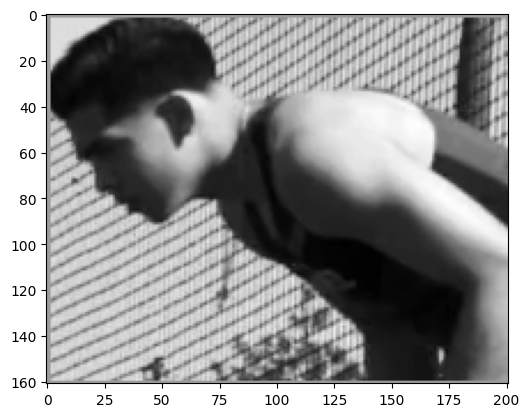

In [35]:
# take region of interest ( take inside of rectangle )
roi_image=frame[y_min:y_max,x_min:x_max]

# convert roi to grayscale
roi_gray=cv2.cvtColor(roi_image,cv2.COLOR_BGR2GRAY) 

# Params for corner detection
feature_params = dict(maxCorners=20,  # We want only one feature
                      qualityLevel=0.2,  # Quality threshold 
                      minDistance=7,  # Max distance between corners, not important in this case because we only use 1 corner
                      blockSize=7)

first_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

# Harris Corner detection
points = cv2.goodFeaturesToTrack(first_gray, mask=None, **feature_params)


# Filter the detected points to find one within the bounding box
for point in points:
    x, y = point.ravel()
    if y_min <= y <= y_max and x_min <= x <= x_max:
        selected_point = point
        break

# If a point is found, convert it to the correct shape
if selected_point is not None:
    p0 = np.array([selected_point], dtype=np.float32)

plt.imshow(roi_gray,cmap="gray")

In [36]:
video_path

'runner.mp4'

In [37]:
import time


# take region of interest ( take inside of rectangle )
roi_image=frame[y_min:y_max,x_min:x_max]

# convert roi to grayscale
roi_gray=cv2.cvtColor(roi_image,cv2.COLOR_BGR2GRAY) 

# Params for corner detection
feature_params = dict(maxCorners=20,  # We want only one feature
                      qualityLevel=0.2,  # Quality threshold 
                      minDistance=7,  # Max distance between corners, not important in this case because we only use 1 corner
                      blockSize=7)

first_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

# Harris Corner detection
points = cv2.goodFeaturesToTrack(first_gray, mask=None, **feature_params)


# Filter the detected points to find one within the bounding box
for point in points:
    x, y = point.ravel()
    if y_min <= y <= y_max and x_min <= x <= x_max:
        selected_point = point
        break

# If a point is found, convert it to the correct shape
if selected_point is not None:
    p0 = np.array([selected_point], dtype=np.float32)
############################ Parameters ####################################

""" 
winSize --> size of the search window at each pyramid level
Smaller windows can more precisely track small, detailed features -->   slow or subtle movements and where fine detail tracking is crucial.
Larger windows is better for larger displacements between frames ,  more robust to noise and small variations in pixel intensity --> require more computations
"""

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(7, 7),  # Window size
                 maxLevel=2,  # Number of pyramid levels
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


############################ Algorithm ####################################

# Read video
cap = cv2.VideoCapture(video_path)

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_frame = cv2.resize(old_frame, None, fx = 0.75, fy = 0.75)


width = old_frame.shape[1]
height = old_frame.shape[0]

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

frame_count = 0
start_time = time.time()

old_gray = first_gray

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx = 0.75, fy = 0.75)

    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if p0 is not None:
        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)  
        good_new = p1[st == 1]  # st==1 means found point
        good_old = p0[st == 1]


        if len(good_new) > 0:
            # Calculate movement
            a, b = good_new[0].ravel()
            c, d = good_old[0].ravel()
 
            # Draw the tracks
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 255, 0), -1)

            img = cv2.add(frame, mask)

            # Calculate and display FPS
            elapsed_time = time.time() - start_time
            fps = frame_count / elapsed_time if elapsed_time > 0 else 0
            cv2.putText(img, f"FPS: {fps:.2f}", (width - 200, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            cv2.imshow('frame', img)

            # Update previous frame and points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)

        else:
            p0 = None

        # Check if the tracked point is out of frame
        if not (25 <= a < width):
            p0 = None  # Reset p0 to None to detect new feature in the next iteration
            selected_point_distance = 0  # Reset selected point distance when new point is detected


    # Redetect features if necessary
    if p0 is None:
        p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
        mask = np.zeros_like(frame)
        selected_point_distance=0
 
    frame_count += 1

    k = cv2.waitKey(25)
    if k == 27:
        break

 
cv2.destroyAllWindows()
cap.release()

## Track small object

In [1]:
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt 

# Path to video
# video_path = "takeoff_2.mp4"
# video_path = "aeroplane_takeoff.mp4"
video_path = "yellowFish.mp4"
# video_path = "bmx.mp4"
# video_path = "runner.mp4"
# video_path = "players.mp4"
video = cv2.VideoCapture(video_path)

# Read the first frame for drawing a rectangle for the desired object
ret, frame = video.read()
frame = cv2.resize(frame, None, fx = 0.3, fy = 0.3)

if not ret:
    print("Failed to read the video.")
    exit()

# Initialize variables for ROI selection
drawing = False  # True if the mouse is pressed
ix, iy = -1, -1  # Initial x, y coordinates of the mouse click
x_min, y_min, x_max, y_max = 0, 0, 0, 0
roi_selected = False  # Flag to check if ROI is selected
roi_gray = None  # To store the grayscale image of ROI
kp1, des1 = None, None  # Keypoints and descriptors of the ROI

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Function to select coordinates by clicking and dragging the mouse
def coordinate_chooser(event, x, y, flags, param):
    global ix, iy, drawing, x_min, y_min, x_max, y_max, roi_selected, roi_gray, kp1, des1

    # Start drawing on left button down
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y
        x_min, y_min = x, y
        x_max, y_max = x, y

    # Update rectangle while moving the mouse
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            x_min, y_min = min(ix, x), min(iy, y)
            x_max, y_max = max(ix, x), max(iy, y)

    # Finalize drawing on left button release
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x_min, y_min = min(ix, x), min(iy, y)
        x_max, y_max = max(ix, x), max(iy, y)
        # Draw the final rectangle on the frame
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        # Save the selected object
        roi_image = frame[y_min:y_max, x_min:x_max]
        if roi_image.size > 0:  # Check if ROI is valid
            roi_gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
            kp1, des1 = sift.detectAndCompute(roi_gray, None)  # Extract keypoints and descriptors
            roi_selected = True
            print("Region of Interest defined and SIFT features extracted.")

    # Reset coordinates with middle button click
    elif event == cv2.EVENT_MBUTTONDOWN:
        print("Reset coordinate data")
        x_min, y_min, x_max, y_max = 0, 0, 0, 0
        roi_selected = False


# Create a window and set the mouse callback function
cv2.namedWindow('coordinate_screen')
cv2.setMouseCallback('coordinate_screen', coordinate_chooser)

while True:
    # Display the frame with the drawn rectangle
    temp_frame = frame.copy()
    if drawing:
        cv2.rectangle(temp_frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
    cv2.imshow("coordinate_screen", temp_frame)

    # Press ESC to exit selection mode
    k = cv2.waitKey(5) & 0xFF
    if k == 27 or roi_selected:  # Exit loop if ESC is pressed or ROI is selected
        break
cv2.destroyAllWindows()

# take region of interest ( take inside of rectangle )
roi_image=frame[y_min:y_max,x_min:x_max]
cv2.imshow("ROI",roi_image)

# convert roi to grayscale
# roi_gray=cv2.cvtColor(roi_image,cv2.COLOR_BGR2GRAY) 
roi_gray= roi_image 

# Params for corner detection
feature_params = dict(maxCorners=20,  # We want only one feature
                      qualityLevel=0.2,  # Quality threshold 
                      minDistance=7,  # Max distance between corners, not important in this case because we only use 1 corner
                      blockSize=7)

first_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

# Harris Corner detection
points = cv2.goodFeaturesToTrack(first_gray, mask=None, **feature_params)


# Filter the detected points to find one within the bounding box
for point in points:
    x, y = point.ravel()
    if y_min <= y <= y_max and x_min <= x <= x_max:
        selected_point = point
        break

# If a point is found, convert it to the correct shape
if selected_point is not None:
    p0 = np.array([selected_point], dtype=np.float32)
############################ Parameters ####################################

""" 
winSize --> size of the search window at each pyramid level
Smaller windows can more precisely track small, detailed features -->   slow or subtle movements and where fine detail tracking is crucial.
Larger windows is better for larger displacements between frames ,  more robust to noise and small variations in pixel intensity --> require more computations
"""

# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize=(8, 8),  # Window size
                 maxLevel=3,  # Number of pyramid levels
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))


############################ Algorithm ####################################

# Read video
cap = cv2.VideoCapture(video_path)

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_frame = cv2.resize(old_frame, None, fx = 0.3, fy = 0.3)


width = old_frame.shape[1]
height = old_frame.shape[0]

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

frame_count = 0
start_time = time.time()

old_gray = first_gray

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx = 0.3, fy = 0.3)

    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    if p0 is not None:
        # Calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)  
        good_new = p1[st == 1]  # st==1 means found point
        good_old = p0[st == 1]


        if len(good_new) > 0:
            # Calculate movement
            a, b = good_new[0].ravel()
            c, d = good_old[0].ravel()
 
            # Draw the tracks
            mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 255, 0), -1)

            img = cv2.add(frame, mask)

            # Calculate and display FPS
            elapsed_time = time.time() - start_time
            fps = frame_count / elapsed_time if elapsed_time > 0 else 0
            cv2.putText(img, f"FPS: {fps:.2f}", (width - 200, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            cv2.imshow('frame', img)

            # Update previous frame and points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1, 1, 2)

        else:
            p0 = None

        # Check if the tracked point is out of frame
        if not (25 <= a < width):
            p0 = None  # Reset p0 to None to detect new feature in the next iteration
            selected_point_distance = 0  # Reset selected point distance when new point is detected


    # Redetect features if necessary
    if p0 is None:
        p0 = cv2.goodFeaturesToTrack(frame_gray, mask=None, **feature_params)
        mask = np.zeros_like(frame)
        selected_point_distance=0
 
    frame_count += 1

    k = cv2.waitKey(25)
    if k == 27:
        break

 
cv2.destroyAllWindows()
cap.release()

Region of Interest defined and SIFT features extracted.


#ALL SIFT

In [1]:
import time
import cv2
import numpy as np
import random

# Path to video
video_path = "bmx.mp4"
video = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = video.read()
frame = cv2.resize(frame, None, fx=0.75, fy=0.75)

if not ret:
    print("Failed to read the video.")
    exit()

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT features in the first frame
old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
kp1, des1 = sift.detectAndCompute(old_gray, None)

# Initialize variables for drawing
mask = np.zeros_like(frame)
colors = [tuple(random.randint(0, 255) for _ in range(3)) for _ in range(len(kp1))]

# Parameters for BFMatcher
bf = cv2.BFMatcher()

frame_count = 0
start_time = time.time()

while True:
    ret, frame = video.read()
    frame = cv2.resize(frame, None, fx=0.75, fy=0.75)

    if not ret:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect SIFT features in the new frame
    kp2, des2 = sift.detectAndCompute(frame_gray, None)

    if des1 is not None and des2 is not None:
        # Match descriptors between the two frames
        matches = bf.knnMatch(des1, des2, k=2)

        # Apply ratio test to keep good matches
        good_matches = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

        # Draw lines between matched keypoints
        for i, match in enumerate(good_matches):
            pt1 = tuple(np.round(kp1[match.queryIdx].pt).astype(int))
            pt2 = tuple(np.round(kp2[match.trainIdx].pt).astype(int))
            color = colors[i % len(colors)]
            mask = cv2.line(mask, pt1, pt2, color, 2)
            frame = cv2.circle(frame, pt2, 5, color, -1)

        img = cv2.add(frame, mask)

        # Calculate and display FPS
        elapsed_time = time.time() - start_time
        fps = frame_count / elapsed_time if elapsed_time > 0 else 0
        cv2.putText(img, f"FPS: {fps:.2f}", (50, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        cv2.imshow('frame', img)

        # Update keypoints and descriptors
        kp1, des1 = kp2, des2
    else:
        # If descriptors are None, reset keypoints
        kp1, des1 = sift.detectAndCompute(frame_gray, None)
        mask = np.zeros_like(frame)

    frame_count += 1

    k = cv2.waitKey(25)
    if k == 27:
        break

cv2.destroyAllWindows()
video.release()
